In [1]:
import numpy as np
from numpy import genfromtxt
import csv
import os

import pysindy as ps

import deepSI
from deepSI import System_data

import matplotlib.pyplot as plt

c:\Users\Joost\anaconda3\envs\test\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_PATH = r"data\\"

WIENER = "WienerHammerBenchmark"
SILVER = "SNLS80mV"
# SILVER = "Schroeder80mV"
# change data set
DATA = SILVER
CSV = ".csv"

PATH = os.path.join(DATA_PATH, DATA+CSV)

# load data
data = genfromtxt(PATH, delimiter=",")

In [3]:
data = data[1:,:-1] # snl
# data = data[1:,2:-1] # schroeder

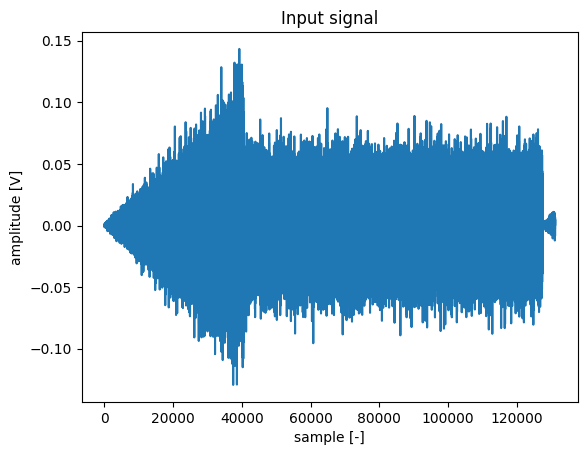

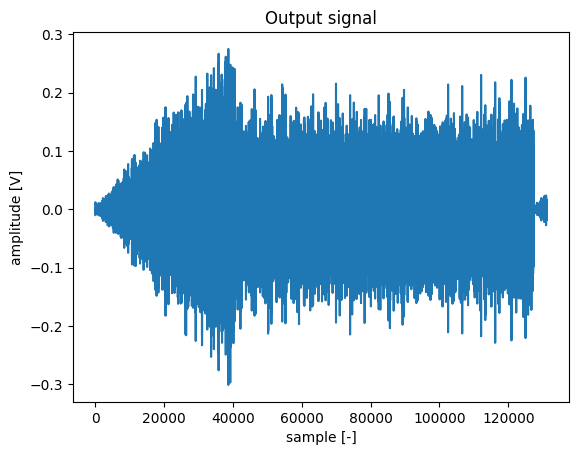

In [4]:
# data
V1 = data[:,0]
V2 = data[:,1]

N = V1.shape[0]
fs = 610.35
dt = 1/fs
t = np.linspace(0,dt*N,N)

plt.plot(V1-np.mean(V1))
plt.xlabel("sample [-]")
plt.ylabel("amplitude [V]")
plt.title("Input signal")
plt.show()

plt.plot(V2-np.mean(V2))
plt.xlabel("sample [-]")
plt.ylabel("amplitude [V]")
plt.title("Output signal")
plt.show()

In [5]:
silver_data = System_data(u=V2,y=V1)

train, test = silver_data[40000:], silver_data[:40000]
print("Training samples: ", train.y.shape[0])
print("Test samples: ", test.y.shape[0])

Training samples:  91072
Test samples:  40000


In [6]:
def NRMS(y_pred, y_true):
    RMS = np.sqrt(np.mean((y_pred-y_true)**2))
    return RMS/np.std(y_true)

In [7]:
# differentiation_method = ps.SINDyDerivative(kind="spline", s=1e-2)
differentiation_method = ps.FiniteDifference(order=4)

x_train = np.stack((train.y[:-1], train.y[1:]), axis=-1)

# model specs
feature_library = ps.ConcatLibrary([ps.PolynomialLibrary(degree=3)]) #ps.IdentityLibrary(),

stlsq_optimizer = ps.STLSQ(alpha=0, threshold=1e-3,verbose=True, normalize_columns=True)#, threshold= 0.03

model = ps.SINDy(feature_library=feature_library,
                 optimizer=stlsq_optimizer
                 )
time = np.linspace(0,dt*train.y.shape[0],train.y.shape[0])
# fit
model.fit(x_train, u=train.u[:-1], t=time[-1])
model.print()
model.coefficients()


x_test = np.stack((test.y[:-1], test.y[1:]), axis=-1)
x_dot_test_predicted = model.predict(x_test, u=test.u[:-1])
time = np.linspace(0,dt*test.y.shape[0],test.y.shape[0])
x_dot_test_simulated = model.simulate(x_test[0], u=test.u[:-1], t=time[:-1])

 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 5.3364e-04 ... 0.0000e+00 ...          8 ... 5.3364e-04
         1 ... 5.3360e-04 ... 0.0000e+00 ...          8 ... 5.3360e-04
(x0)' = -0.002 x0 + 0.005 x1
(x1)' = -0.005 x0 + 0.003 x1


NRMS pred 1:  1.0353428370746516
NRMS simo 1:  1.0001184781748944


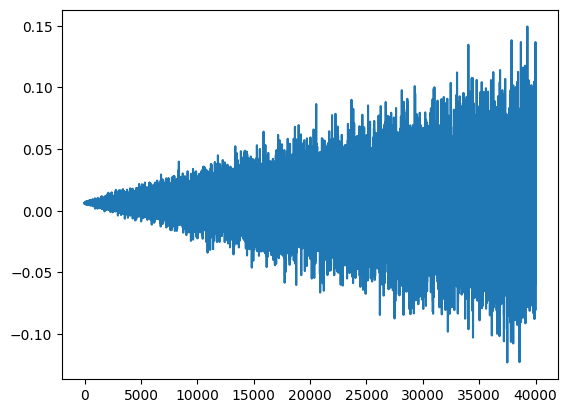

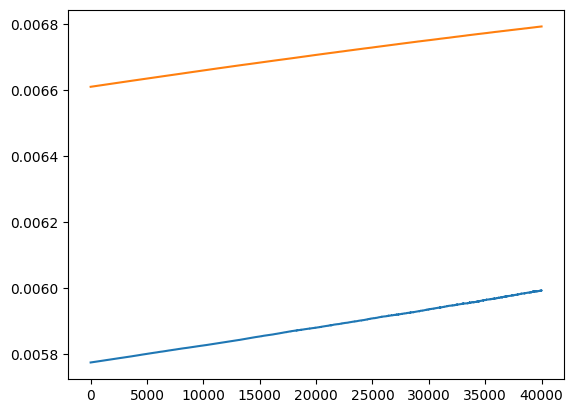

In [8]:
pred_NRMS = NRMS( x_dot_test_predicted[:,0], test.y[1:])
simo_NRMS = NRMS( x_dot_test_simulated[:,0], test.y[:-2])

print("NRMS pred 1: ",pred_NRMS)
print("NRMS simo 1: ",simo_NRMS)

plt.plot(test.y)
plt.show()
plt.plot(x_dot_test_simulated[:,:])
plt.show()

# plt.plot(test.y)
# plt.plot(x_dot_test_predicted[:,0]-test.y[1:])
# plt.ylabel("Amplitude [V]")
# plt.xlabel("Time [samples]")
# plt.title("Prediction, NRMS = "+str(pred_NRMS))
# plt.legend(["True","Residual"])
# plt.show()

# plt.plot(test.y)
# plt.plot(x_dot_test_simulated[1:,0]-test.y[:-2])
# plt.ylabel("Amplitude [V]")
# plt.xlabel("Time [samples]")
# plt.title("Prediction, NRMS = "+str(simo_NRMS))
# plt.legend(["True","Residual"])
# plt.show()

In [9]:
arrow_head_data = System_data(u=V1[arrow_head_idx],y=V2[arrow_head_idx])
_, arrow_test = arrow_head_data.train_test_split(split_fraction=1.0)

x_arrow_test = np.stack((arrow_test.y[:-1], arrow_test.y[1:]), axis=-1)

x_arrow_predicted = model.predict(x_arrow_test, u=arrow_test.u[:-1])
x_arrow_simulated = model.simulate(x_arrow_test[0], u=arrow_test.u[:-1], t=arrow_test.u.shape[0]-1)

pred_NRMS = NRMS( x_arrow_predicted[:,0], arrow_test.y[1:])
simo_NRMS = NRMS( x_arrow_simulated[1:,0], arrow_test.y[:-2])

print("NRMS pred 1: ",pred_NRMS)
print("NRMS simo 1: ",simo_NRMS)

NameError: name 'arrow_head_idx' is not defined

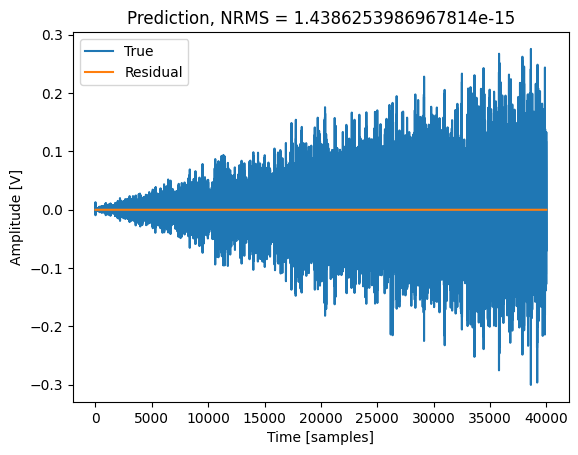

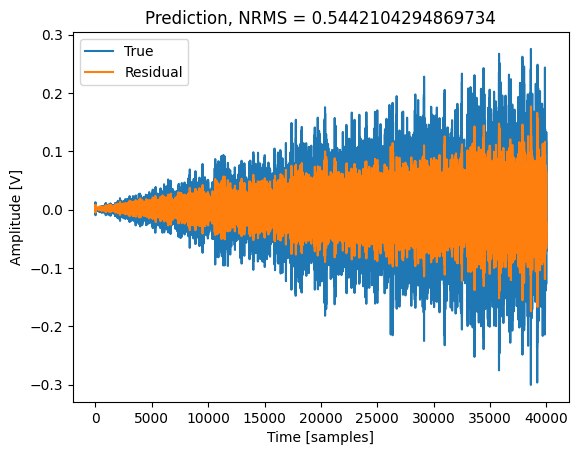

In [ ]:
plt.plot(arrow_test.y)
plt.plot(x_arrow_predicted[:,0]-arrow_test.y[1:])
plt.ylabel("Amplitude [V]")
plt.xlabel("Time [samples]")
plt.title("Prediction, NRMS = "+str(pred_NRMS))
plt.legend(["True","Residual"])
plt.show()

plt.plot(arrow_test.y)
plt.plot(x_arrow_simulated[1:,0]-arrow_test.y[:-2])
plt.ylabel("Amplitude [V]")
plt.xlabel("Time [samples]")
plt.title("Prediction, NRMS = "+str(simo_NRMS))
plt.legend(["True","Residual"])
plt.show()